In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import scipy.stats as stats
import seaborn as sns

import torchdeepretina.io as io
import stimuli
import torchdeepretina.stimuli as tdrstim

from tqdm import tqdm

import os

import deepdish as dd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fftpack import fft, fftshift, fftfreq
from scipy.interpolate import interp1d

import pyret.filtertools as ft
import torchdeepretina as tdr

import pickle

f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [2]:
prename = "convgc_"
prepath = '/home/grantsrb/src/torch-deep-retina/models/'
savefolder = "FigureUpdates_March2023/"
caption_file = "caption.txt"

path_to_data = "/home/TRAIN_DATA/"
nat_color = 'lightcoral'
whit_color = '#888888'

In [3]:
captions = dict()

In [4]:
# Load the Data
dataset = "15-10-07"
cells = "all"
stim_type = "naturalscene"
bsize = 1000
props_fname = "polarity_rev/{}polarity_reversals.p".format(prename)
dsets = [ "15-10-07", "15-11-21a", "15-11-21b", ]
stypes = ["naturalscene", "whitenoise"]

if os.path.exists(props_fname):
    with open("polarity_rev/{}polarity_reversals.p".format(prename), "rb") as f:
        proportions = pickle.load(f)
else:
    mdl_paths = []
    for dset in dsets:
        for stype in stypes:
            mdl_paths.append(prepath+prename+dset+"_"+stype+".pt")
            
    proportions = {
        "path": [],
        "props": [],
        "dots": [],
    }
    for path in mdl_paths:
        print("Evaluating", path)
        proportions["path"].append(path)
        model, hyps = io.load_model(path, ret_hyps=True)
        temporal_depth = model.img_shape[0]
        mean = hyps['norm_stats']['mean']
        std =  hyps['norm_stats']['std']
        norm_stats = [mean, std]
        test_data = tdr.datas.loadexpt(dataset, cells, stim_type, 'test',
                                             temporal_depth, nskip=0,
                                             norm_stats=norm_stats,
                                             data_path=path_to_data)
        model.eval()
        model.cuda()
        props = []
        dots = []
        for ci in range(model.n_units):
            print("Cell Index", ci)
            irfs = tdr.utils.get_stim_grad(model, torch.FloatTensor(test_data.X), layer="output",
                                           cell_idx=ci, batch_size=bsize, to_numpy=True)
            rf = irfs.mean(0).reshape(-1)
            dot = np.dot(irfs.reshape(len(irfs),-1), rf)
            dots.append(dot)
            prop = (dot>0).mean() # Proportion positive
            props.append(prop)
        proportions["props"].append(props)
        proportions["dots"].append(dots)
        
        # maybe need to use ab instead of wb
    with open(props_fname, "wb") as f:
        pickle.dump(proportions, f)

In [5]:
for i in range(len(proportions["dots"])):
    for j in range(len(proportions["dots"][i])):
        proportions["props"][i][j] = (proportions["dots"][i][j]>0).mean()


In [6]:
df = {
    "stype": [],
    "dtype": [],
    "cell_idx":    [],
    "prop":  [],
    "polar_rev": []
}

thresh = 0.001
n_samps = 100
dots = {
    "whitenoise": [],
    "naturalscene": [],
}
# Sample the same portion of the dot products from each cell for the dots dict
perm = np.random.permutation(proportions["dots"][0][0])[:n_samps].astype("int")
for i in range(len(proportions["dots"])):
    splt = proportions["path"][i].split("_")
    stype = splt[-1].split(".")[0]
    dtype = splt[-2]
    for ci in range(len(proportions["dots"][i])):
        dots[stype].append(proportions["dots"][i][ci][perm])
        df["stype"].append(stype)
        df["dtype"].append(dtype)
        df["cell_idx"].append(ci)
        prop = (proportions["dots"][i][ci]<0).mean()
        df["prop"].append(prop)
        df["polar_rev"].append(prop > thresh and prop < (1-thresh))
df = pd.DataFrame(df)
df.head()

,stype,dtype,cell_idx,prop,polar_rev
0,naturalscene,15-10-07,0,0.206514,True
1,naturalscene,15-10-07,1,0.215413,True
2,naturalscene,15-10-07,2,0.184352,True
3,naturalscene,15-10-07,3,0.222801,True
4,naturalscene,15-10-07,4,0.166555,True


In [7]:
for stype in stypes:
    print(stype, "Proportion With Polarity Reversal:", df.loc[df["stype"]==stype]["polar_rev"].mean())

naturalscene Proportion With Polarity Reversal: 1.0
whitenoise Proportion With Polarity Reversal: 0.8846153846153846


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


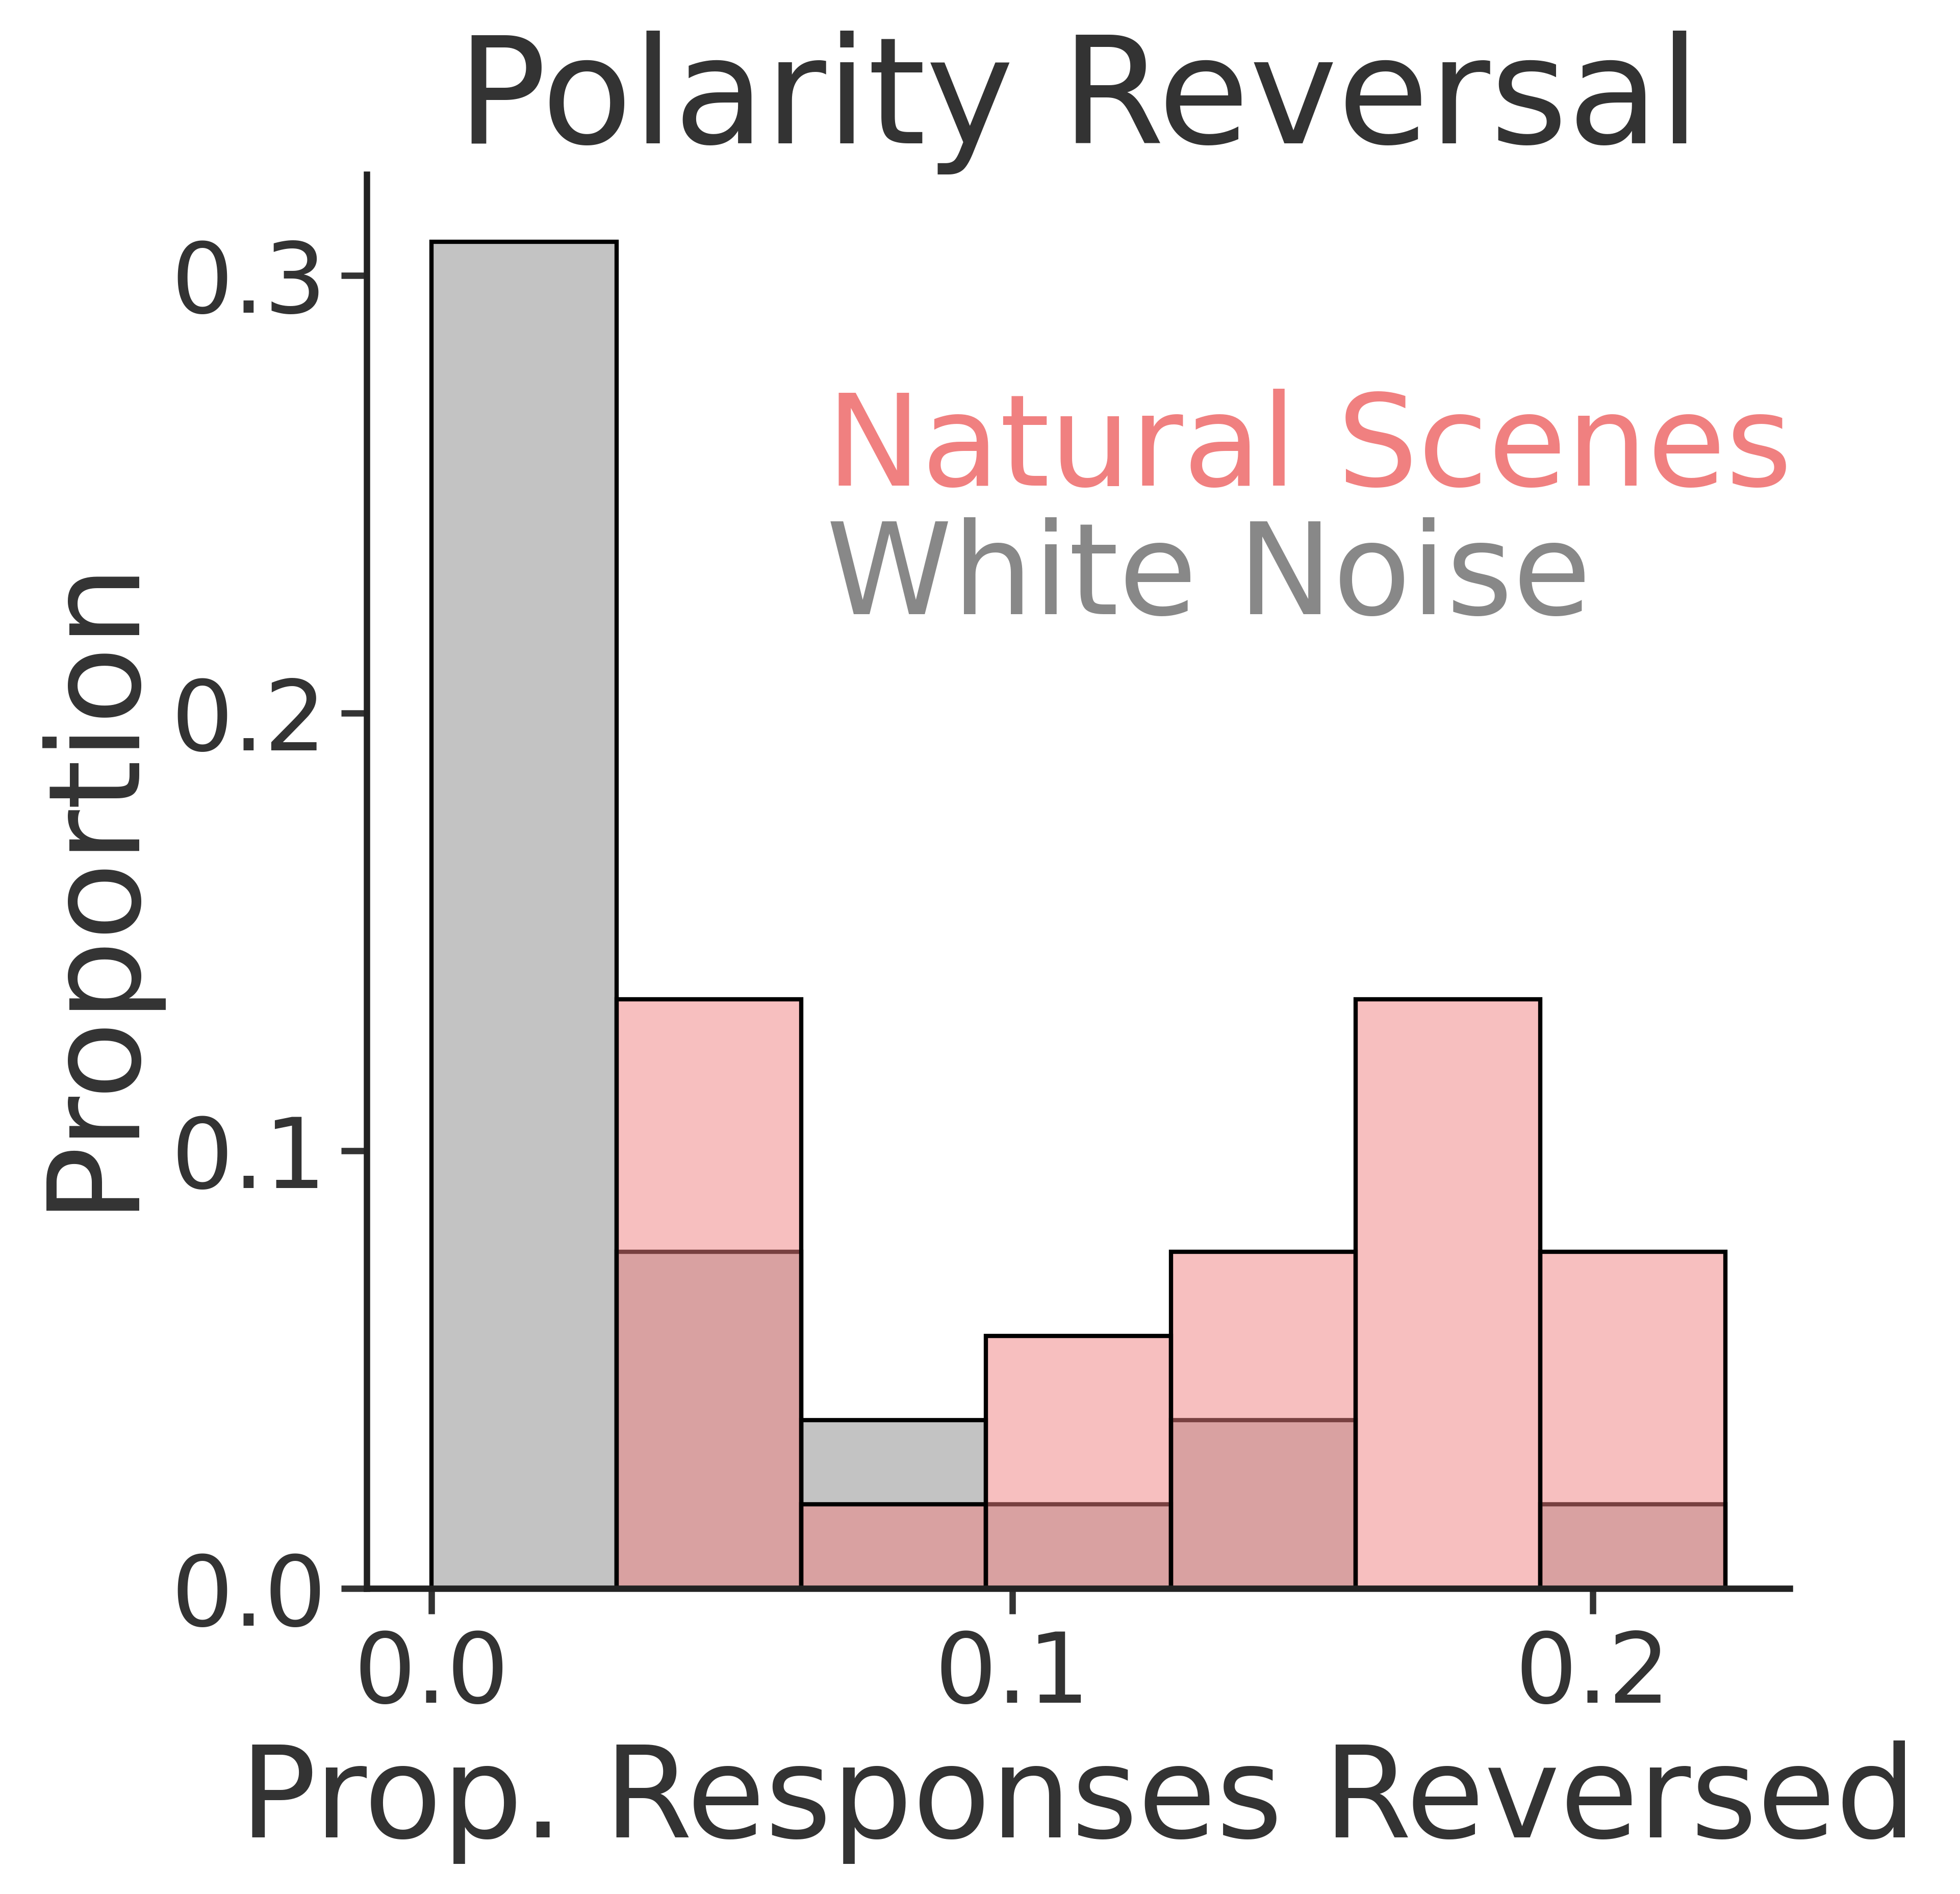

In [9]:
fontsize = 30
titlesize = 35
ticksize = 23
plt.style.use('deepretina.mplstyle')
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.histplot(x="prop", hue="stype", data=df, stat="proportion", ax=ax, palette={"whitenoise": whit_color, "naturalscene": nat_color})

plt.xlabel("Prop. Responses Reversed", fontsize=fontsize)
plt.ylabel("Proportion", fontsize=fontsize)
plt.yticks([0,0.1,0.2,0.3], fontsize=ticksize)
plt.xticks([0,0.1,0.2], fontsize=ticksize)
plt.legend().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
plt.title("Polarity Reversal", fontsize=titlesize)

ax.annotate('White Noise', xy=(0.45, 0.75), #xycoords='axes points',
            xycoords="figure fraction",
            size=30, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(0.45, 0.82), #xycoords='axes points',
            xycoords="figure fraction",
            size=30, ha='left', va='top',
            bbox=None,
            color=nat_color)
            

folder_name = "polarity_rev"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}polarity_rev_props_hist".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
Histogram of each cell's proportion of responses that invert the sign of their mean receptive field.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

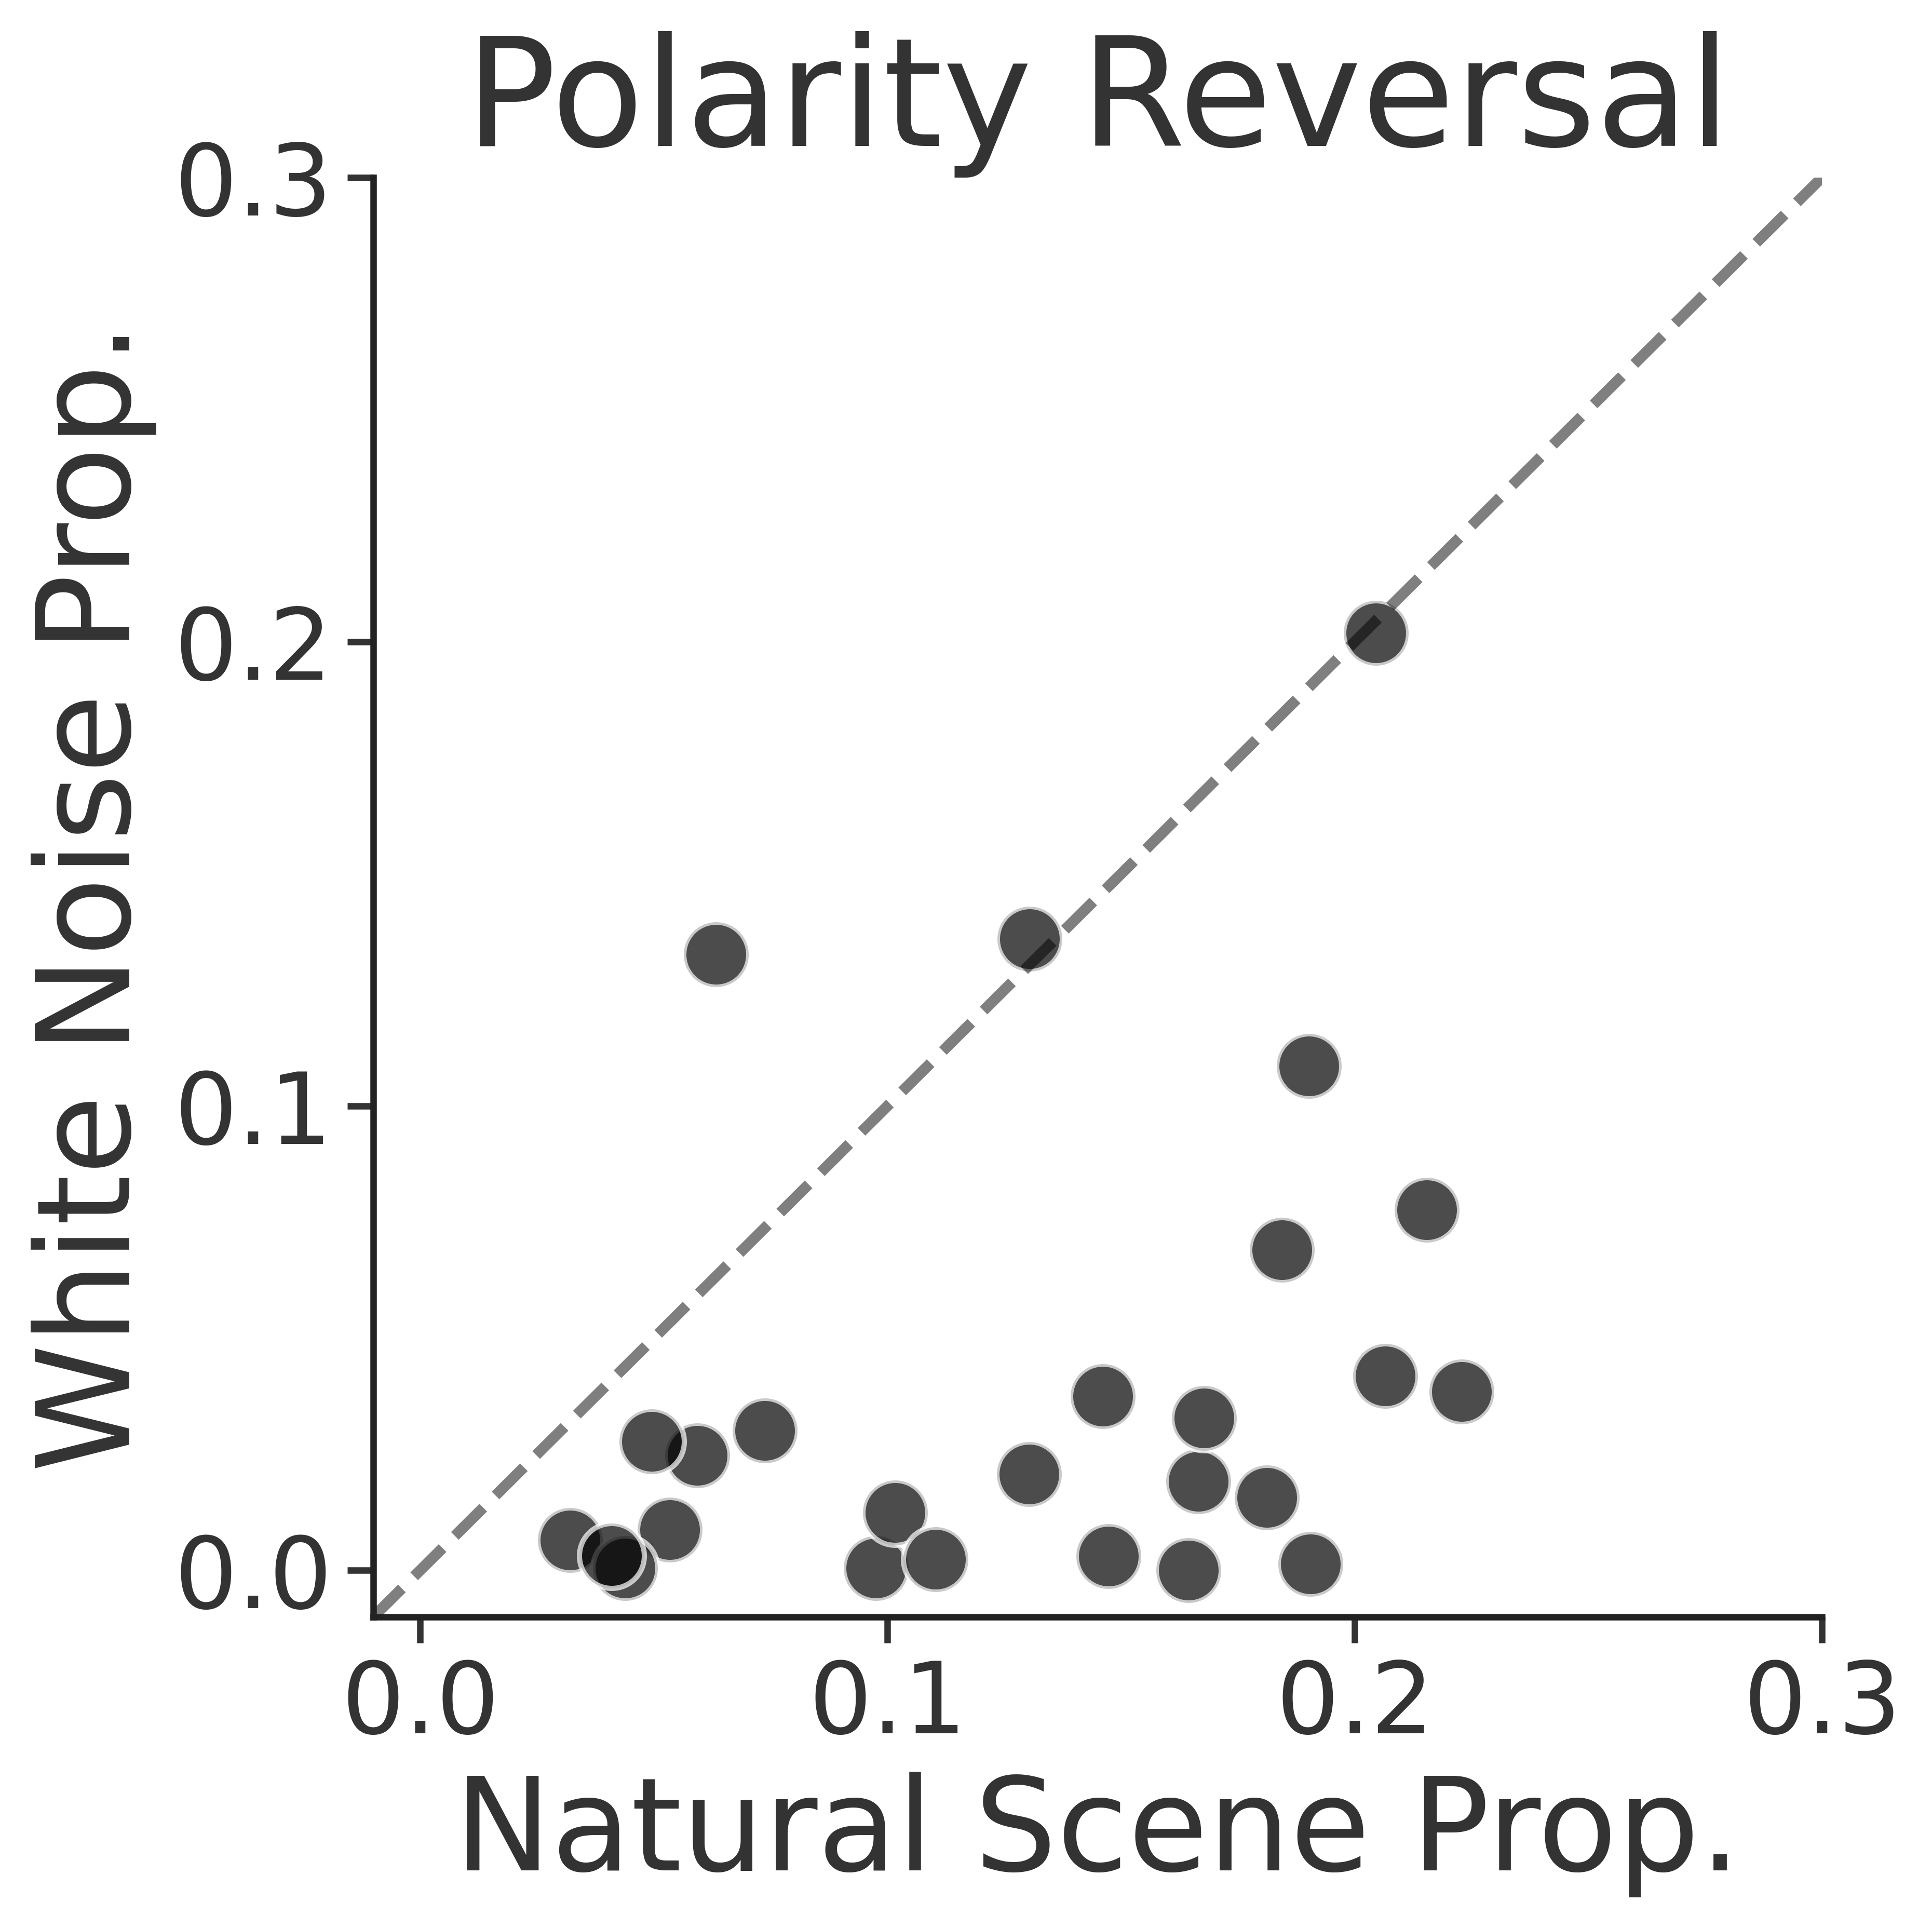

In [10]:
cols = ["stype", "dtype", "cell_idx"]
y = np.asarray(df.loc[df["stype"]=="whitenoise"].sort_values(by=cols)["prop"])
x = np.asarray(df.loc[df["stype"]=="naturalscene"].sort_values(by=cols)["prop"])

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x=x,y=y, ax=ax, alpha=0.7, color="black")
ticks = [0,0.1, 0.2, 0.3]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
#lim = [-1, 41]
lim = [ticks[0]-0.01,ticks[-1]]
plt.ylim(lim)
plt.xlim(lim)
ax.plot(np.linspace(lim[0], lim[1], 4), np.linspace(lim[0], lim[1], 4), "--k", alpha=0.5)
#ax.plot(np.linspace(lim[0], lim[1], 4), [0 for i in range(4)], "--k", alpha=0.5)
plt.ylabel("White Noise Prop.", fontsize=fontsize)
plt.xlabel("Natural Scene Prop.", fontsize=fontsize)
plt.title("Polarity Reversal", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "polarity_rev"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}polarity_rev_props_scatter".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
White Noise model proportion reversed cell responses plotted against Natural Scenes model proportion reversed cell responses for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

In [11]:
wn_dots = np.concatenate(dots["whitenoise"], axis=0)
ns_dots = np.concatenate(dots["naturalscene"], axis=0)

In [11]:
fontsize = 25
titlesize = 35
ticksize = 23
alpha = 1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


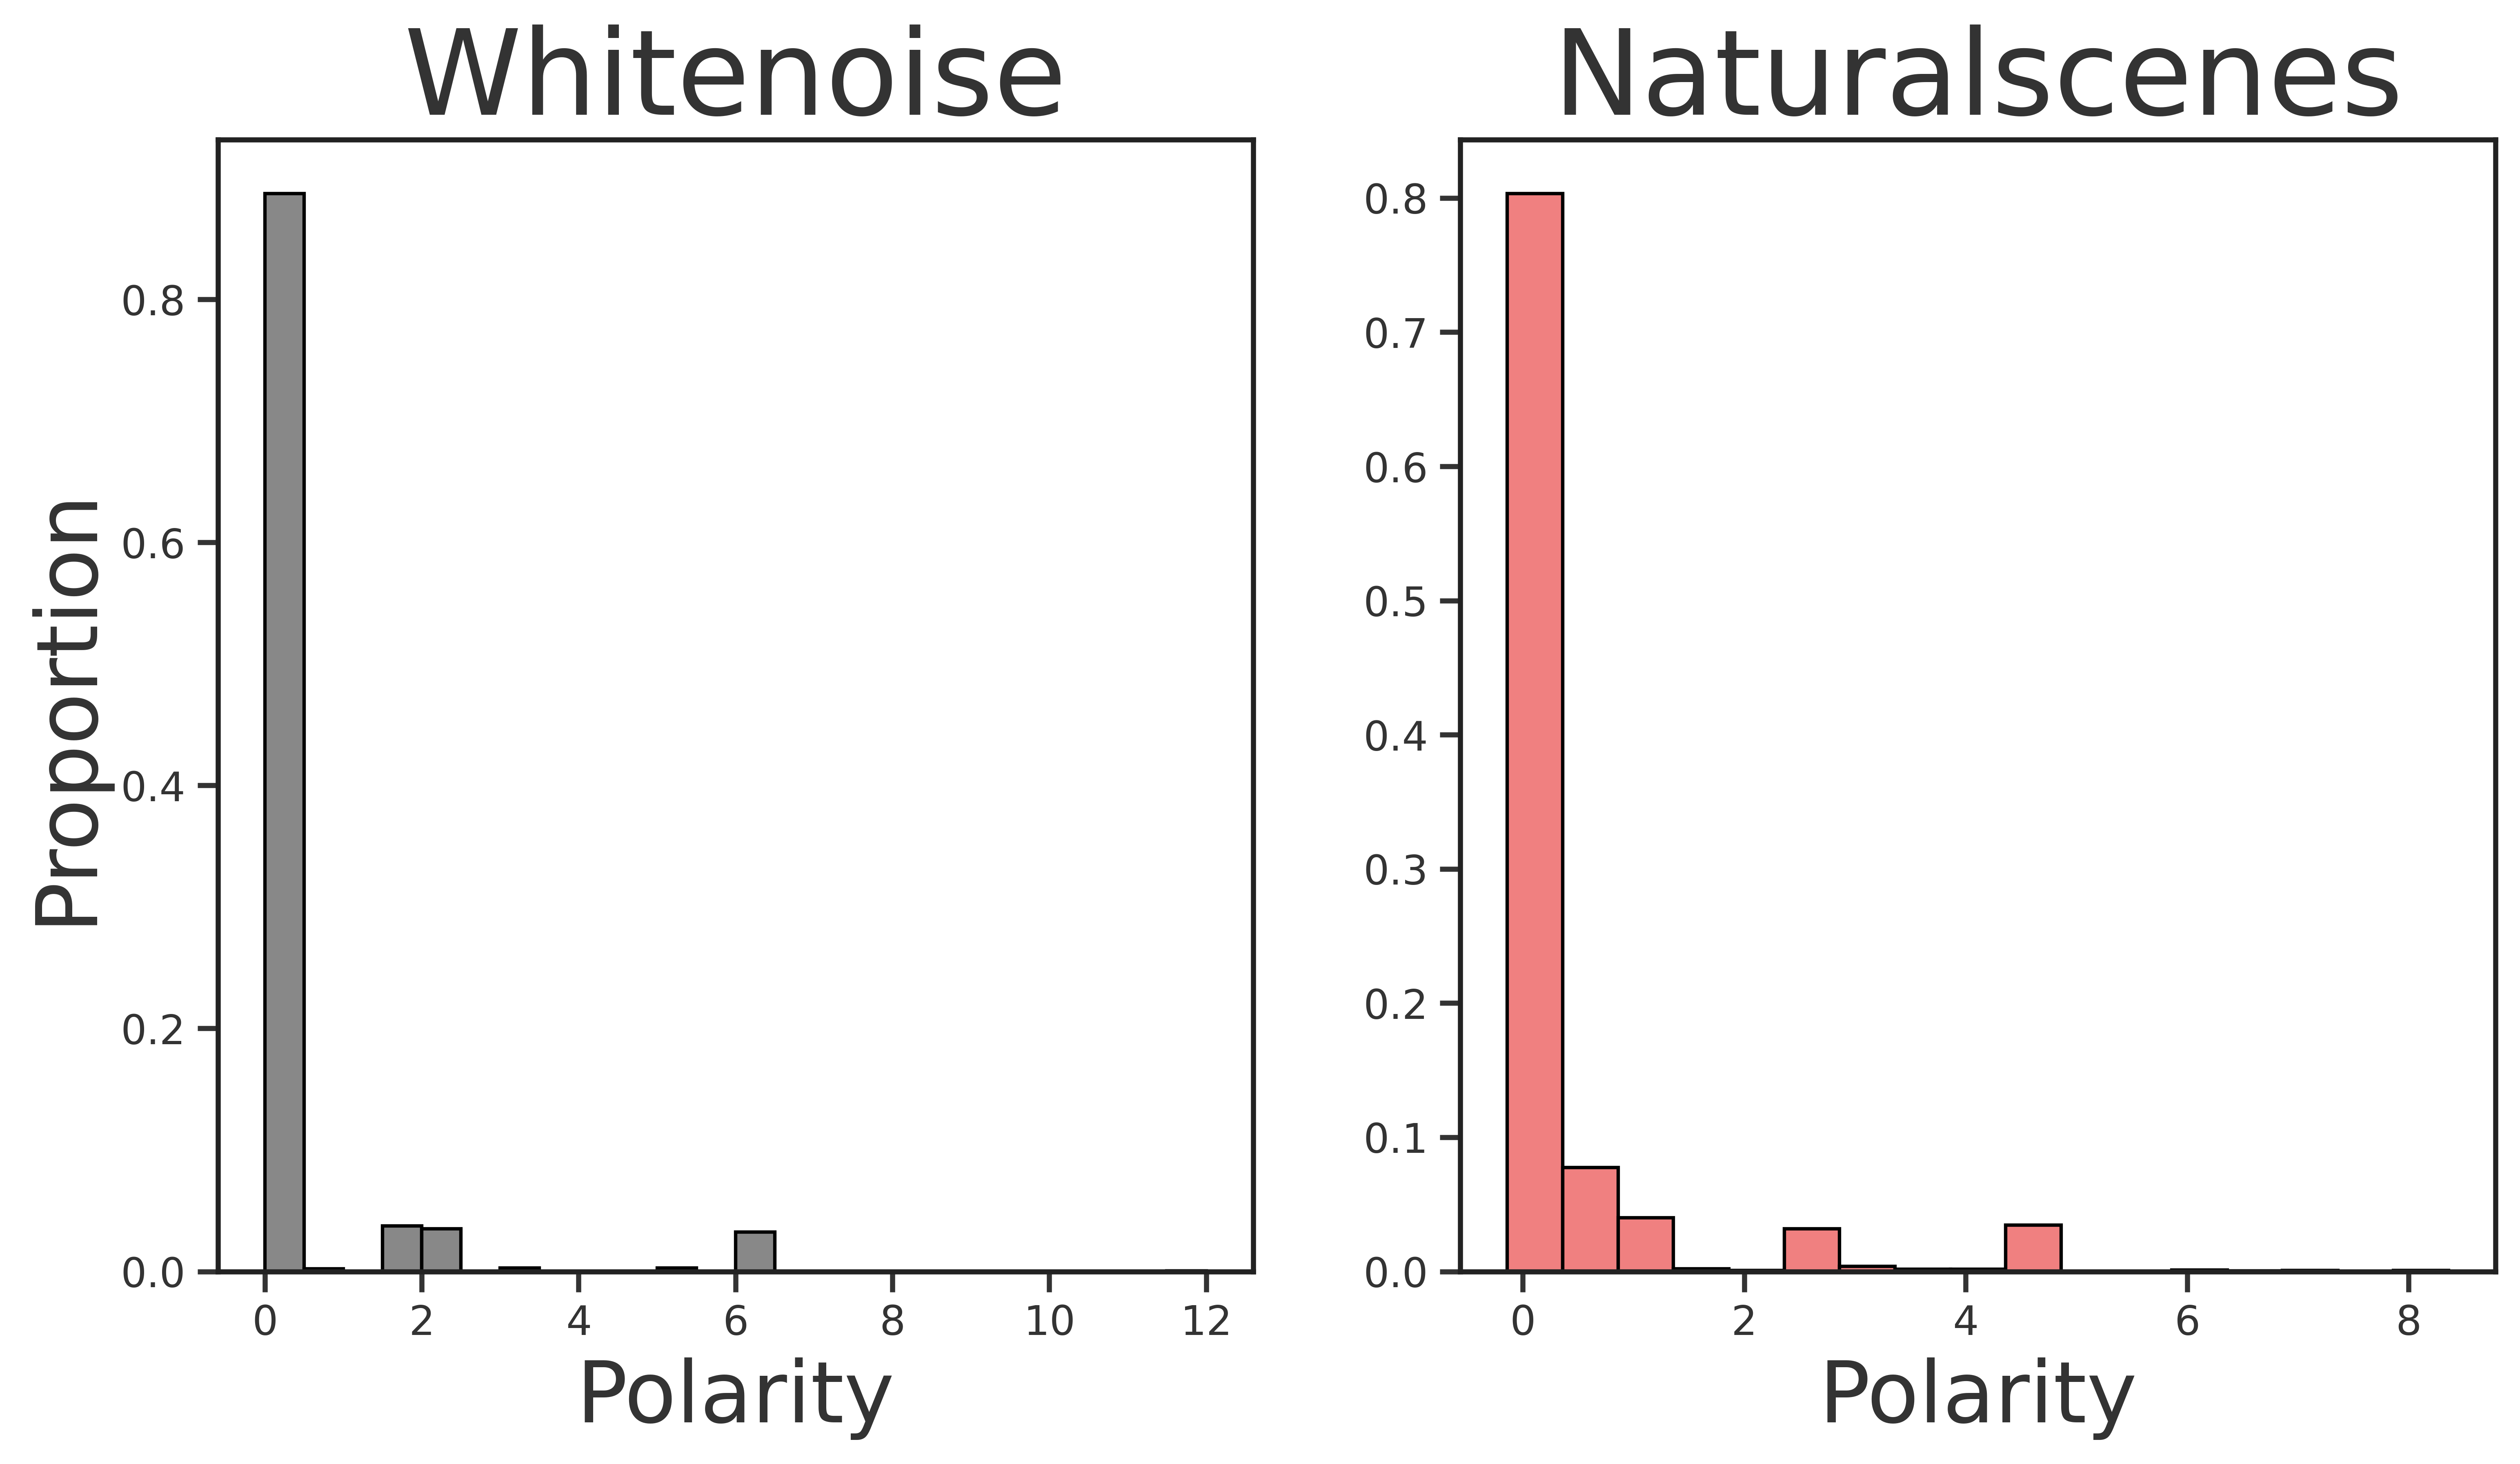

In [12]:
binwidth=0.5

fig,axes = plt.subplots(1,2,figsize=(12,6))

ax = axes[0]
plt.sca(ax)
sns.histplot(wn_dots, stat="proportion", ax=ax, color=whit_color, alpha=alpha, binwidth=binwidth)
#ylim = [0,0.42]
#yticks = [i/10 for i in range(int(ylim[1]*10)+1)]
#plt.xticks([-6,-2,2],fontsize=ticksize)
#plt.yticks(yticks, fontsize=ticksize)
#plt.ylim(ylim)
plt.ylabel("Proportion", fontsize=fontsize)
plt.xlabel("Polarity", fontsize=fontsize)
plt.title("Whitenoise", fontsize=titlesize)

ax = axes[1]
plt.sca(ax)
sns.histplot(ns_dots, stat="proportion", ax=ax, color=nat_color, alpha=alpha, binwidth=binwidth)
#plt.xticks(fontsize=ticksize)
#plt.yticks(yticks, ["" for _ in yticks])
#plt.ylim(ylim)
plt.ylabel("")
plt.xlabel("Polarity", fontsize=fontsize)
plt.title("Naturalscenes", fontsize=titlesize)

#folder = os.path.join(savefolder, "polarity_rev")
#if not os.path.exists(folder):
#    os.makedirs(folder)
#save_name = os.path.join(folder, "{}polarity_rev_dots_hist".format(prename))
#plt.savefig(save_name + ".png", bbox_inches="tight")
#plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()